## <center>Identificação de Batimentos Cardíacos e Frequência Cardíaca</center>
  
  

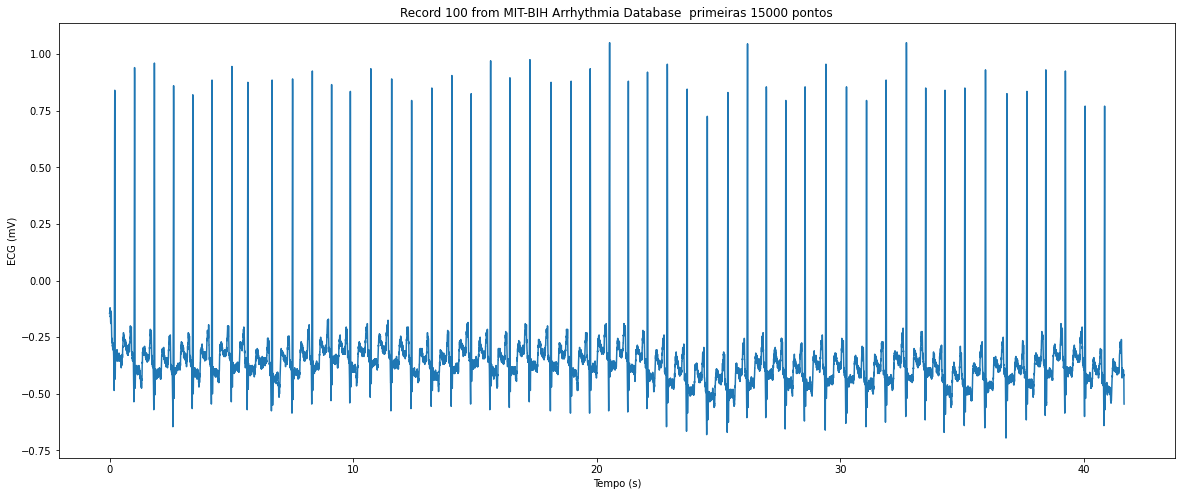

In [2]:
""" Código desenvolvido por: Matheus Gama Costa
    Os sinais utilizados para o teste dos códigos foram extraidos do site:
    <https://physionet.org/>
    Os algoritmos de identificação implementados tem como base o algoritmo desenvolvido por Pan-Tompkins:
    <Pan, Jiapu; Tompkins, Willis J. (March 1985). "A Real-Time QRS Detection Algorithm". IEEE Transactions on Biomedical Engineering. BME-32 (3): 230–236. doi:10.1109/TBME.1985.325532>
         """
# Importando bibliotecas
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import wfdb

# Lendo os 15000 primeiros pontos do sinal referente ao Paciente 100 - MIT – BIH
sig, fields = wfdb.rdsamp('dados/100', channels=[0], sampto=15000)
ann_ref = wfdb.rdann('dados/100','atr', sampto=15000) # abrindo as anotações de referência
fs = fields['fs'] # lendo a frequência de amostragem
x = np.arange(len(sig[:,0])) # criando um vetor para com o tamanho do sinal
time = x/fs # utilizando o vetor anterior para monta o vetor tempo em segundos
fig, ax = plt.subplots(figsize=(20, 8)) # craia a figura para plotagem
# a seguir plota-se o sinal lido 
ax.plot(time, sig[:,0])
ax.set_title('Record 100 from MIT-BIH Arrhythmia Database  primeiras 15000 pontos')
ax.set_xlabel('Tempo (s)')
ax.set_ylabel('ECG (mV)')
plt.show()

In [6]:
# A seguir foi implementado um código para identificação dos picos R com base no algoritmo de Pan_Tompkins as funções possuem seus cabeçalhos especificos para melhor entendimento das variáveis de entrada e sua funcionalidade

def detect_R(signal, rate, WINDOW_SEC = 0.15, MIN_RR = 0.33, MAX_RR = 2.0):
    """ Função para detecção de picos R
        Signal: O sinal em que os picos R serão buscados
        rate: A frequência de amostragem do sinal
        WINDOW_SEC: fator de ajuste do tamanho da janela em relação a frequencia de amostragem
        MIN_RR : ajuste do numero minimo intervalo RR em relação a frequencia de amostragem
        MAX_RR : ajuste do numero máximo intervalo RR em relação a frequencia de amostragem """

    buffer, samples_delay = filter_signal(signal, rate) # cria um vetor com o sinal filtrado e um valor de atraso com referência a amostragem para ajudar no ajuste da posição dos picos
    buffer = normalize(buffer) # normaliza o sinal filtrado

    buffer = compute_derivative(buffer) # calcula a derivada do final filtrado
    buffer = normalize(buffer) # normaliza a derivada do sinal filtrado
    buffer = [x * x for x in buffer] # eleva ao quadrado a derivada do sinal filtrado

    samples_window = round(WINDOW_SEC * rate) # cria a partir do valor de ajuste e da fs o número de amostras na janela
    integrated = window_integration(buffer, samples_window) # aplica a janela de integração móvel ao sinal tratado anteriormente
    samples_delay += samples_window // 2 # adiciona ao atraso metade do tamanho da janela definida anteriormente

    min_rr_samples = round(MIN_RR * rate) # calcula o numero minimo de picos R dentro da janela
    max_rr_samples = round(MAX_RR * rate)# calcula o numero máximo de picos R dentro da janela
    indices = thresholding(integrated, min_rr_samples, max_rr_samples) # define os threshold com base em Pan-Tompkins
    indices = [x - samples_delay for x in indices] # atrasa os indices encontrados no threshold
    return correct_peaks(signal, rate, indices) #retorna os indices com as posições dos picos corrigidos

def filter_signal(ecg, rate, LOWER_FILTER_HZ = 5.0, UPPER_FILTER_HZ = 15.0):
    """ Função para filtrar o filtro passabanda do sinal 
        ECG : Sinal a ser filtrado
        rate: frequência de amostragem
        LOWER_FILTER_HZ : Frequência Filtro passa baixas
        UPPER_FILTER_HZ : Frequência filtro passa altas"""
    nyq = 0.5 * rate # frequência de nyquist
    lower = LOWER_FILTER_HZ / nyq # limite inferior para o filtro
    upper = UPPER_FILTER_HZ / nyq # limite superior para o filtro
    b, a = signal.butter(2, [lower, upper], 'bandpass') # calculo dos coeficientes do filtro
    result = signal.filtfilt(b, a, ecg) # aplicando o filtro ao sinal
    delay = int(0.06 * rate) # gerando um delay de 6% da frequência de amostragem
    return result, delay

def normalize(values):
    """ Função para normalizar valore
        values : Valores a serem normalizados """
    max_value = max(values) # calcula os valores maximos do vetor
    return [item / max_value for item in values] # retorna o vetor com suas posições divididas pelo maximo

def compute_derivative(signal):
    """ Realiza o cclculo das derivadas de um sinal
        signal : sinal a ser derivado """
    return np.diff(signal) # retorna as diferencas entre as posiç]ões do vetor


def window_integration(signal, window_size):
    """ Função para realizar a integração da janela móvel
        siglan : sinal a ser aplicado a integração
        window_size : tamanho da janela de integração """
    result = []
    value = 0
    for i, x in enumerate(signal): # intera sobre as posições e valores do vetor
        first = i - (window_size - 1) # define a pprimeira posição dentro da janela
        value += x / window_size # soma ao value o valor do sinal da presente interação dividido pelo tamnaho da janela
        if first > 0: #caso o valor inicial seja maior que 0
            value -= signal[first - 1] / window_size # subtrai de value o valor do sinal da posição anterior a first dividido pelo tamanho da janela
        result.append(value) # adiciona o value ao resultado a ser retornado
    return result


def thresholding(integrated, min_rr_width, max_rr_width):
    """ Função para definir o treshold variável para a detecção dos picos R com base no algoritmo de Pan-Tompkins
        integragetd : sinal comma janela de integração aplicada
        min_rr_width : minimo de intervalos RR dentro da janela a ser considerados
        max_rr_width : máximo de intervalos RR dentro da janela a ser considerados """
    spki = 0 #level do sinal
    npki = 0#level do ruído
    peaks = [] #vetor para os picos
    threshold1 = spki #threshold 1
    threshold2 = spki #threshold 2
    searchback = False #definição para a busca dos valores anteriores
    searchback_end = 0 # posição para final da busca dos valores anteriores
    previous = 0 #valor anterior
    i = 2 
    while i < len(integrated) - 2:
        if i - previous > max_rr_width and i - searchback_end > max_rr_width: # se a posição atual menos a anterior for maior que o tamanho maximo de intervalos r assim como a posição atual menos o final da busca para trás
            searchback = True # busca para trás verdade
            searchback_end = i #atribui a posição atual ao final da busca para trás
            i = previous + 2 #asume a posição atual como a anterior mais duas
            continue
        if searchback and i == searchback_end: # se a busca para tras for verdadeira e a posição atual for igual ao final da busca
            searchback = False #busca para tras falso
            continue
        peaki = integrated[i]#lé o pico atual como sendo o valor do sinal na posição atual
        if peaki < integrated[i - 2] or peaki <= integrated[i + 2]: # se o pico atual for menos do que o sinal na posição anterior ou menor ou igual ao da posição seguinte
            i += 1 # posição atual se torna a próxima
            continue

        is_R = False # inicializa a definição se o pico atual é um pico R
        if searchback: # se a busca para tras é verdadeira
            if peaki > threshold2: # o pico atual é maior que o valor limite 2
                spki = 0.750 * spki + 0.250 * peaki # level do sinal segue o método do artigo
                is_R = True # ele é um pico R
        elif peaki > threshold1: # caso a busca para tras seja falsa e o pico é maior que o limite 1 
            spki = 0.875 * spki + 0.125 * peaki# level do sinal segue o método do artigo
            is_R = True# ele é um pico R

        if is_R:# caso o sinal é um pico R
            if previous == 0 or i - previous >= min_rr_width: # a posição anterior é igual a zero ou a posição atual menos a anterior é maior ou igual ao número minimo de picos r na janela
                peaks.append(i) #insere a posição atual como sendo a posição de um pico R
            elif integrated[previous] < peaki:# caso contrário e o sinal na posição anterior é menor que a do pico
                peaks[-1] = i # insere ao final do vetor de picos a posição atual
            previous = i# a posição anterior é igual a atual
        else: # se não for pico R
            npki = 0.875 * npki + 0.125 * peaki # calcula o nível do ruído como no artigo

        threshold1 = npki + 0.25 * (spki - npki)#calcula o threshold inicial como no artigo
        threshold2 = 0.5 * threshold1#calcula o threshold seguinte
        i += 1 #proxíma posição 
    return peaks


def correct_peaks(signal, rate, peaks):
    """ Função para corrigir a posição dos picos R
        signal : sinal que gerou os picos R
        rate : frequencia de amostragem do sinal
        peaks : picos já identificados assumindo a função de treshold """
    left_add = int(0.075 * rate) # assume um valor de 7.5% da frequencia de amostragem para ir para trás
    right_add = int(0.075 * rate) # assume um valor de 7.5% da frequencia de amostragem para ir para frente
    i = 0

    while i < len(peaks):#itera sopre as posições do vetor de picos
        old_index = peaks[i]#o indice do pico antigo é igual ao indice na posição atual
        begin = max(old_index - left_add, 1)# inicia inicio o valor do indice do pico como sendo o valor máximo do indice atual menos o deslocamento para a esquerda
        end = min(old_index + right_add, len(signal) - 1) # inicia final com o valor do indice do pico como sendo o valor minimo entre indice atual mais o deslocamento para a direita e o tamanho do sinal menos um
        baseline = (signal[begin] + signal[end]) / 2 # define a linha de base como sendo a média entre o valor do sinal na posição inicial mais o sinal na posição final
        max_value = np.absolute(signal[old_index] - baseline) #o valor maximo é o valor absoluto do sinal na posição antiga menos a linha de base
        new_index = old_index #o novo indice é igual ao antigo
        for j in range(begin, end): #itera entre a posição inicial e final
            value = np.absolute(signal[j] - baseline) #o valor atual é igual ao sinal na posição da iteração atual menos a linha de base
            if value > max_value: # se o valor for maior que o valor máximo
                max_value = value # o calor maximo vai ser o valor atual
                new_index = j #o novo indice vai ser o indece da iteração atual
        if new_index != old_index: # se o indice novo for diferente do antigo
            peaks[i] = new_index # o pico na posição atual do vetor de pico receberá o novo valor do indice
        i += 1
    return peaks

def compute_hr(sig_len, R_inds, fs):
    """ Função para calcular a frequência cardíaca e os intervalos RR
        sig_len : tamanho do sinal onde os intervalos RR estão
        R_inds : indices dos picos R
        fs : frequência de amostragem do sinal """
    heart_rate = np.full(sig_len, np.nan, dtype='float32')# cria um array de NaN's com o tamanho do sinal

    for i in range(0, len(R_inds)-2): #itera sobre o vetor de indices
        a = R_inds[i] # lê a posição do primeiro pico R
        b = R_inds[i+1] # lê a posição do proximo pico R
        c = R_inds[i+2] # Lê a posição do pico R seguinte
        rr = (b-a) * (1.0 / fs) * 1000 # calcula o tempo do intervalo RR em ms
        hr = 60000.0 / rr # calcula o valor dos batimentos em batimentos por minuto
        heart_rate[b+1:c+1] = hr # assume que entre dois picos R o valor do batimento cardiaco é o mesmo

    RR = (np.diff(R_inds)/fs)*1000 # calcula o tempo do intervalo R em ms para retornar
    heart_rate[R_inds[-1]:] = heart_rate[R_inds[-1]] # preeenche as ultimas posições do vetor de batimentos cardiácos com o valor calculado

    return heart_rate, RR

In [7]:
peaks = detect_R(sig[:,0], fs) # identifica os picos R
HR, RR = compute_hr(sig_len=len(sig[:,0]), R_inds=peaks, fs=fs) # calcula a frequência cardíaca e os ingervalos entre os picos R

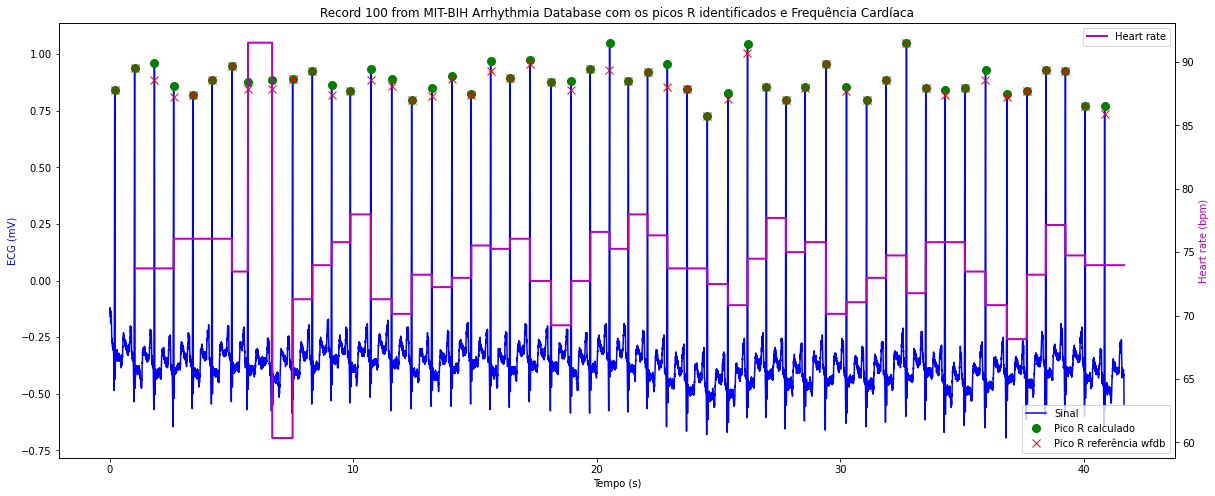

In [8]:
# a seguir serão plotados os picos R identificados com o código implementado e os valores dos picos R presentes nas anotaç~eos do sinal utilizado. Também serão apresentados os valores da frequência cardíaca ao longo do tempo
fig, ax_left = plt.subplots(figsize=(20, 8))
ax_right = ax_left.twinx()

x_peaks =np.array(peaks)/fs
x_Peaks_ref = (ann_ref.sample[1:]/fs)
ax_left.plot(time, sig[:,0], color='b', label='Sinal')
ax_left.plot(x_peaks, sig[peaks,0], 'go', label='Pico R calculado', markersize=8)
ax_left.plot(x_Peaks_ref, sig[ann_ref.sample[1:],0], 'rx', label='Pico R referência wfdb', markersize=8)
ax_right.plot(time, HR, label='Heart rate', color='m', linewidth=2)

ax_left.set_title('Record 100 from MIT-BIH Arrhythmia Database com os picos R identificados e Frequência Cardíaca')
ax_left.set_xlabel('Tempo (s)')
ax_left.set_ylabel('ECG (mV)', color='b')
ax_right.set_ylabel('Heart rate (bpm)', color='m')
ax_left.legend(loc="lower right")
ax_right.legend(loc="upper right")
plt.show()

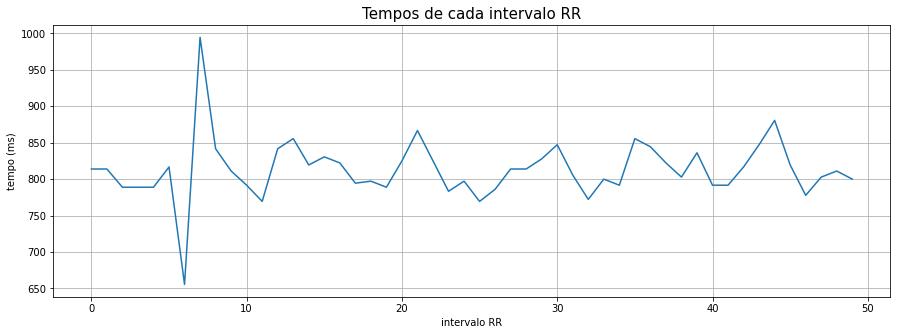

In [9]:
# a seguir serão apresentados os intervalos dos picos R em ms
plt.figure(figsize=(15, 5))
plt.plot(RR)
plt.title('Tempos de cada intervalo RR', fontdict = {'fontsize': 15})
plt.xlabel('intervalo RR')
plt.ylabel('tempo (ms)')
plt.grid()